In [1]:
import gzip
from pathlib import Path

In [2]:
import h5py
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from scipy.stats.stats import pearsonr
from matplotlib import pyplot as plt

In [3]:
#BASE_DIR = Path("/mnt/g/My Drive/CloudVault/Masters/Data")
BASE_DIR = Path("/home/jakob/Cloudvault_new/Data")

# Paths of imported embeddings file
EMBEDDING_FILE = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'05-embedding'/'netoglyc4_protein_embeddings_netsurfp_output_glyc_labels_max.h5'

# Path of NetOGlyc 4 output (gzipped)
NETOGLYC4_OUTPUT = BASE_DIR/'NetOGlyc5 data'/'Training NetOGlyc4'/'predictions4_0.tsv'

# Maximum sequence length of proteins for test set
#MAX_SEQ_LENGTH = 1022
MAX_SEQ_LENGTH = 34350

IGNORE_MISSING_IDS = True

In [4]:
with h5py.File(EMBEDDING_FILE, 'r') as file:
    identifiers_list = file['identifiers'].asstr()[:].tolist()
    sequences_list = file['sequences'].asstr()[:].tolist()
    seq_lengths = [len(seq) for seq in sequences_list]
    gly = file['labels']['gly'][:, :MAX_SEQ_LENGTH, 0]

In [5]:
#testing_ids = set(identifiers_list)

In [6]:
positive_glycosites_df = pd.read_csv(NETOGLYC4_OUTPUT, sep="\t", header=0)
print(f"Proteins: {len(positive_glycosites_df)}")

Proteins: 19678


In [7]:
positive_glycosites_df

,uniprot,sites
0,P30492,"202,214"
1,P16189,"202,206"
2,Q9TQE0,"89,119,129"
3,P30510,"202,214,219,301"
4,P30154,48
...,...,...
19673,P60852,"141,143,146,155,157,158,161,163,167,168,171,17..."
19674,Q6X784,NaN
19675,Q8TCW7,"314,325,326,328,332,345,352,355,359,361"
19676,P21754,"33,301,303,306,308,329,331,333,341,344,346,348..."


In [8]:
len(positive_glycosites_df['uniprot'].unique()) == len(positive_glycosites_df)

True

In [9]:
identifier_positive_scores = {}

for i, row in positive_glycosites_df.iterrows():
    if pd.notna(row['sites']):
        glycosites = [int(site)-1 for site in row['sites'].split(',')]
    else:
        glycosites = []
    identifier_positive_scores[row['uniprot']] = glycosites

In [10]:
print(f"Maximum sequence length in output: {max(max(glycosites) for glycosites in identifier_positive_scores.values() if len(glycosites) > 0)}")

Maximum sequence length in output: 8728


In [11]:
print(f"Minimum index in output: {min(min(glycosites) for glycosites in identifier_positive_scores.values() if len(glycosites) > 0)}")

Minimum index in output: 9


In [12]:
missing_scoring_identifiers = set(identifiers_list) - set(identifier_positive_scores)
if len(missing_scoring_identifiers) > 0:
    if not IGNORE_MISSING_IDS:
        raise Exception(f"{len(missing_scoring_identifiers)} test identifiers not found in scores: {missing_scoring_identifiers}")

if len(missing_scoring_identifiers) > 0:
    print(f"Ignoring following {len(missing_scoring_identifiers)} missing test identifiers: {missing_scoring_identifiers}")

testing_scores = {protein_id: identifier_positive_scores[protein_id] for protein_id in (set(identifiers_list) - missing_scoring_identifiers)}

Ignoring following 1 missing test identifiers: {'Q8WXI7'}


In [13]:
unambiguous_pred = []
unambiguous_labels = []

for identifier in testing_scores:
    scores = testing_scores[identifier]
    embedding_idx = identifiers_list.index(identifier)
    seq_length = min(len(sequences_list[embedding_idx]), MAX_SEQ_LENGTH)
    
    labels = gly[embedding_idx, :seq_length]
    site_mask = (labels >= 0)
    unambiguous_site_mask = (labels == 0) | (labels == 1)
    
    pred = np.zeros(seq_length)
    for idx in scores:
        pred[idx] = 1

    unambiguous_pred.append(pred[unambiguous_site_mask])
    unambiguous_labels.append(labels[unambiguous_site_mask])

unambiguous_pred = np.concatenate(unambiguous_pred)
unambiguous_labels = np.concatenate(unambiguous_labels)

In [14]:
def plot_roc_curve(labels, pred, title="Receiver operating characteristic"):
    fpr, tpr, _ = roc_curve(labels, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def calculate_metrics(unambiguous_labels, unambiguous_pred):
    print(f"% of unambiguous sites glycosylated: {(unambiguous_labels > 0).sum() / len(unambiguous_labels) * 100}")
    print(f"Accuracy for unambiguous sites: {accuracy_score(unambiguous_labels, unambiguous_pred)}")
    print(f"MCC for unambiguous sites: {matthews_corrcoef(unambiguous_labels, unambiguous_pred)}")
    print(f"ROC-AUC for unambiguous sites: {roc_auc_score(unambiguous_labels, unambiguous_pred)}")

    tn, fp, fn, tp = confusion_matrix(unambiguous_labels, unambiguous_pred).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"Sensitivity (TPR) for unambiguous sites: {sensitivity*100:.2f}%")
    print(f"Specificity (TNR) for unambiguous sites: {specificity*100:.2f}%")

    plot_roc_curve(unambiguous_labels, unambiguous_pred, "Receiver operating characteristic for unambiguous sites")


NetOGlyc-4.0 predictions for full NetOGlyc-4.0 training dataset (5097 sites):

% of unambiguous sites glycosylated: 36.138905238375514
Accuracy for unambiguous sites: 0.8854227977241514
MCC for unambiguous sites: 0.7498481750571251
ROC-AUC for unambiguous sites: 0.8711708871843368
Sensitivity (TPR) for unambiguous sites: 81.98%
Specificity (TNR) for unambiguous sites: 92.26%


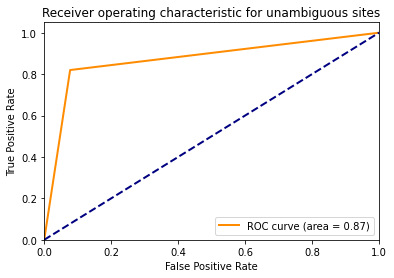

In [20]:
print(f"NetOGlyc-4.0 predictions for full NetOGlyc-4.0 training dataset ({len(unambiguous_labels)} sites):\n")
calculate_metrics(unambiguous_labels, unambiguous_pred)